# IBM Capstone Project: The Battle of the Neighborhoods

### I will determine which is the best place to open a Peruvian Restaurant in Barcelona, Spain
* I will analyze the city of Barcelona and its neighbourhoods using this web page https://en.wikipedia.org/wiki/Districts_of_Barcelona
* I will convert address data into their equivalent latitude and longitude values defining a function
* I will use the Foursquare API to explore the  neighborhoods and to get venues in neighborhoods.
* I  will use the Foursquare API to get venue ratings in neighborhoods.
* I will use the k-means clustering  to complete clustering task
* I will use the Folium library to visualize the neighborhoods, venues , clusters

## 1. Exploring data set

1.1 Import libraries

In [1]:
!pip install geopy    
!pip install folium   
!pip install geocoder
print('Enviroments installed')

     |████████████████████████████████| 102kB 16.5MB/s ta 0:00:01
     |████████████████████████████████| 102kB 6.3MB/s ta 0:00:011
Enviroments installed


In [2]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import json
from geopy.geocoders import Nominatim
import geocoder
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
from pandas.io.json import json_normalize
from folium.plugins import HeatMap

print('Libraries installed')

Libraries installed


1.2 Get the coordinates of Barcelona

In [3]:
barcelona_address = 'Barcelona, Spain'

geolocator = Nominatim(user_agent="spain_explorer")
location = geolocator.geocode(barcelona_address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(barcelona_address, latitude, longitude))

The geograpical coordinate of Barcelona, Spain are 41.3828939, 2.1774322.


1.3 Neighbourhood data of Barcelona

In [4]:
url = "https://en.wikipedia.org/wiki/Districts_of_Barcelona"
source = requests.get(url).text
soup = BeautifulSoup(source,'lxml')

neighborhoodList = []
table = soup.find('table',{'class':'wikitable'})
table_rows = table.find_all('tr')
data = []
for row in table_rows:
    data.append([t.text.strip() for t in row.find_all('td')])

df_barcelona = pd.DataFrame(data, columns=['Number', 'District', 'Size', 'Population', 'Density', 'Neighbourhoods','Councilman','Party'])

#Eliminate not assigned rows
df_barcelona = df_barcelona[~df_barcelona['Number'].isnull()]
df_barcelona = df_barcelona.reset_index()

print("There are {} districs in {}".format(df_barcelona.shape[0], barcelona_address))
df_barcelona.shape

There are 10 districs in Barcelona, Spain


(10, 9)

1.3 Modification of the data

In [5]:
#Eliminate not useful columns 
df_barcelona=df_barcelona.drop(columns=['Councilman', 'Party','Size', 'Density','index'])

In [6]:
df_barcelona.head(5)

,Number,District,Population,Neighbourhoods
0,1,Ciutat Vella,"111,290","La Barceloneta, El Gòtic, El Raval, Sant Pere,..."
1,2,Eixample,"262,485","L'Antiga Esquerra de l'Eixample, La Nova Esque..."
2,3,Sants-Montjuïc,"177,636","La Bordeta, la Font de la Guatlla, Hostafrancs..."
3,4,Les Corts,"82,588","les Corts, la Maternitat i Sant Ramon, Pedralbes"
4,5,Sarrià-Sant Gervasi,"140,461","El Putget i Farró, Sarrià, Sant Gervasi - la B..."


In [7]:
#Separate the neighbourhood of each district

df_barcelona=(df_barcelona.set_index(['Number', 'District','Population'])
   .stack()
   .str.split(',', expand=True)
   .stack()
   .unstack(-2)
   .reset_index(-1, drop=True)
   .reset_index()
)

df_barcelona.head(5)

,Number,District,Population,Neighbourhoods
0,1,Ciutat Vella,"111,290",La Barceloneta
1,1,Ciutat Vella,"111,290",El Gòtic
2,1,Ciutat Vella,"111,290",El Raval
3,1,Ciutat Vella,"111,290",Sant Pere
4,1,Ciutat Vella,"111,290",Santa Caterina i la Ribera


1.4 Get geographical coordinates of neighbourhoods

In [8]:
def get_latlng(neighbourhoods):
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, {}'.format(neighbourhoods,barcelona_address))
        lat_lng_coords = g.latlng
    return lat_lng_coords

coords = [ get_latlng(neighbourhoods) for neighbourhoods in df_barcelona["Neighbourhoods"].tolist() ]

df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])


df_barcelona['Latitude'] = df_coords['Latitude']
df_barcelona['Longitude'] = df_coords['Longitude']

df_barcelona.head()

,Number,District,Population,Neighbourhoods,Latitude,Longitude
0,1,Ciutat Vella,"111,290",La Barceloneta,41.38185,2.19151
1,1,Ciutat Vella,"111,290",El Gòtic,41.38280,2.17727
2,1,Ciutat Vella,"111,290",El Raval,41.37763,2.17145
3,1,Ciutat Vella,"111,290",Sant Pere,41.40177,2.16258
4,1,Ciutat Vella,"111,290",Santa Caterina i la Ribera,42.28390,2.01892


1.5 Creating the map of Barcelona with neighbourhoods superimposed

In [9]:
map_barcelona= folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng,  neighbourhoods in zip(df_barcelona['Latitude'], df_barcelona['Longitude'], df_barcelona['Neighbourhoods']):
    label = '{}'.format(neighbourhoods)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_barcelona)  
    
map_barcelona

## 2. The venues and its analysis

2.1 Initiate Foursquare

In [10]:
CLIENT_ID = 'JAWT00P4N3T3XS25V0QCJRYQMSEHHDMGVUCM0A5WZAI4T25X' 
CLIENT_SECRET = 'W4RZTHR5ZJW3WJ1HGZRWN5Y4MF4FQSENEUQJ4AKUJD5JKIZK' 
VERSION = '20180605' 
LIMIT=100

2.2 Get the 100 top venues of each neighbourhood

In [11]:
def getNeighbourhoodsVenues( latitude, longitude,neighbourhoods, radius=1000 ):
    venues = []
    for lat, long, neighbourhoods in zip(latitude, longitude ,neighbourhoods):

       
        url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            long,
            radius, 
            LIMIT)

   
        results = requests.get(url).json()["response"]['groups'][0]['items']
    
        for venue in results:
            venues.append((
                neighbourhoods,
                lat, 
                long, 
                venue['venue']['name'], 
                venue['venue']['id'], 
                venue['venue']['location']['lat'], 
                venue['venue']['location']['lng'],  
                venue['venue']['location']['distance'],  
                venue['venue']['categories'][0]['name']))
    
    
    venues = pd.DataFrame(venues)
  
    venues.columns = ['Neighbourhoods', 'Latitude', 'Longitude', 'VenueName', 'VenueId', 'VenueLatitude', 'VenueLongitude','VenueDistance','VenueCategory']
            
    return venues 

neighbourhoods_venues = getNeighbourhoodsVenues (df_barcelona['Latitude'], df_barcelona['Longitude'], df_barcelona['Neighbourhoods'] )

print('There are {} unique venue categories. Some of them are as below:'.format(len(neighbourhoods_venues['VenueCategory'].unique())))
neighbourhoods_venues.head()

There are 284 unique venue categories. Some of them are as below:


,Neighbourhoods,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory
0,La Barceloneta,41.38185,2.19151,Baluard Barceloneta,4c5144e3375c0f475ed8ae93,41.380047,2.189250,275,Bakery
1,La Barceloneta,41.38185,2.19151,BRO,535ea7db498e522c6b801a4f,41.380214,2.189007,277,Burger Joint
2,La Barceloneta,41.38185,2.19151,Platja de la Barceloneta (Playa de la Barcelon...,4c0d3610d64c0f47665e265d,41.379610,2.193038,280,Beach
3,La Barceloneta,41.38185,2.19151,Somorrostro,4b9165c4f964a5202bb933e3,41.379156,2.189100,361,Spanish Restaurant
4,La Barceloneta,41.38185,2.19151,acqua&farina,5b3bd6684420d8003919ee61,41.381023,2.190152,146,Pizza Place


2.4 The top categories of venues

In [12]:
print('Top 10 distinct venue counts are as below')
neighbourhoods_venues[['VenueId','VenueCategory']].drop_duplicates().groupby('VenueCategory').count()[['VenueId']].rename(columns={"VenueId": "Count"}).sort_values(by=['Count'], ascending=False)[:10]

Top 10 distinct venue counts are as below


,Count
VenueCategory,
Spanish Restaurant,137
Tapas Restaurant,120
Mediterranean Restaurant,109
Restaurant,108
Hotel,98
Café,86
Bakery,82
Plaza,77
Pizza Place,70


2.5 Lets find only the peruvian resturants and restaurants in general

In [13]:
restaurant_list =['Restaurant', 'Spanish Restaurant','Tapas Restaurant','Mediterranean Restaurant','Pizza Place', 'Burger Joint', 'Italian Restaurant','Japanese Restaurant','Seafood Restaurant', 'Asian Restaurant','Mexican Restaurant', 'Paella Restaurant','Bistro', 'Vegetarian / Vegan Restaurant']
peruvian_restaurant_list = ['Peruvian Restaurant', 'Latin Restaurant']

neighbourhoods_venues['RestFlag']=False
for restCat in restaurant_list:
    neighbourhoods_venues['RestFlag'] = neighbourhoods_venues['RestFlag'] | neighbourhoods_venues['VenueCategory'].str.contains(restCat)
    
neighbourhoods_restaurants = neighbourhoods_venues[neighbourhoods_venues['RestFlag'] == True].iloc[:,:-1]
peruvian_restaurants = neighbourhoods_restaurants[ neighbourhoods_restaurants['VenueCategory'].isin(peruvian_restaurant_list) ]
other_restaurants = neighbourhoods_restaurants[ ~neighbourhoods_restaurants['VenueCategory'].isin(peruvian_restaurant_list) ]

print('Total number of restaurants:', len(neighbourhoods_restaurants['VenueId'].unique()))
print('Total number of Peruvian restaurants:', len(peruvian_restaurants['VenueId'].unique()))
print('Percentage of Peruvian restaurants: {:.2f}%'.format(len(peruvian_restaurants['VenueId'].unique()) / len(neighbourhoods_restaurants['VenueId'].unique()) * 100))

Total number of restaurants: 948
Total number of Peruvian restaurants: 7
Percentage of Peruvian restaurants: 0.74%


2.6 Lets see which neighbourhood has a peruvian restaurant and which doesnt

67 neighborhoods do not have any Peruvian restaurant


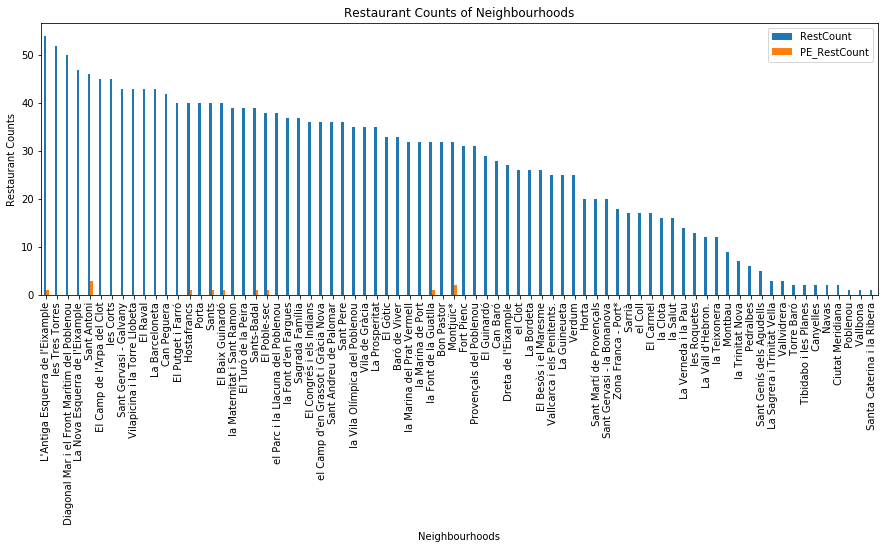

In [14]:
# Total amount of restaurants per Neighbourhood
restaurant_counts =  neighbourhoods_restaurants.groupby(['Neighbourhoods']).count().rename(columns={"VenueCategory": "RestCount"})[['RestCount']]

#Which neighbourhood doesnt have restaurants??
noRestList = list(set(neighbourhoods_venues['Neighbourhoods']) - set(neighbourhoods_restaurants['Neighbourhoods']))

## Appending it to count it
if noRestList != []:
    restaurant_counts = restaurant_counts.append (pd.DataFrame( {'Neighbourhoods' : noRestList  , 'RestCount': [0] * len(noRestList) } ).set_index('Neighbourhoods'))

restaurant_counts.reset_index(inplace=True)

# Peruvian restaurants per Neighborhood
per_rest_counts =  peruvian_restaurants.groupby(['Neighbourhoods']).count().rename(columns={"VenueCategory": "PE_RestCount"})[['PE_RestCount']]

#which ones dont have any peruvian restaurants?
noRestList = list(set(neighbourhoods_venues['Neighbourhoods']) - set(peruvian_restaurants['Neighbourhoods']))

#append them to count them
if noRestList != []:
    per_rest_counts = per_rest_counts.append (pd.DataFrame( {'Neighbourhoods' : noRestList  , 'PE_RestCount': [0] * len(noRestList) } ).set_index('Neighbourhoods'))

per_rest_counts.reset_index(inplace=True)
restaurant_counts= restaurant_counts.merge(per_rest_counts).set_index('Neighbourhoods')
restaurant_counts= restaurant_counts.sort_values(by=['RestCount'],ascending =False)

print('{} neighborhoods do not have any Peruvian restaurant'.format(len(noRestList)))

#Drawing everythin in a graph
restaurant_counts[['RestCount','PE_RestCount']].plot(kind='bar',figsize=(15,5))
plt.title('Restaurant Counts of Neighbourhoods')
plt.xlabel('Neighbourhoods')
plt.ylabel('Restaurant Counts')
plt.show()

2.7 Lets make a heat map to see restaurants  along with cyan dots that represent the peruvian restaurants


In [15]:
barcelona_center = [latitude, longitude]
map_restaurant= folium.Map(location=barcelona_center, zoom_start=12)
df_neighborhood_noPErest = df_barcelona[df_barcelona['Neighbourhoods'].isin(noRestList)]

folium.TileLayer('cartodbpositron').add_to(map_barcelona) 
HeatMap(neighbourhoods_restaurants[['VenueLatitude','VenueLongitude']]).add_to(map_restaurant)
folium.Marker(barcelona_center).add_to(map_barcelona)
folium.Circle(barcelona_center, radius=2000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(barcelona_center, radius=4000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(barcelona_center, radius=6000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(barcelona_center, radius=10000, fill=False, color='black').add_to(map_restaurant)
for lat, lon, neig, name in zip(peruvian_restaurants['VenueLatitude'], peruvian_restaurants['VenueLongitude'], peruvian_restaurants['Neighbourhoods'], peruvian_restaurants['VenueName']):
    label = folium.Popup(str(name) + ' - ' + str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='cyan',
        fill=True,
        fill_color='cyan',
        fill_opacity=0.7).add_to(map_restaurant)
              
map_restaurant

There some peruvian restaurants 4km away from the center and 2km away, not in the center


### From heat map , we can see that there are not enough peruvian restaurants in the main center but there is high number of restaurants in Barcelona in general 

2.8 Lets see the neighbourhood without peruvian restaurants too (cyan dots)

In [16]:
barcelona_center = [latitude, longitude]
map_restaurant= folium.Map(location=barcelona_center, zoom_start=12)

df_neighborhood_noPErest = df_barcelona[df_barcelona['Neighbourhoods'].isin(noRestList)]

folium.TileLayer('cartodbpositron').add_to(map_barcelona) 
HeatMap(neighbourhoods_restaurants[['VenueLatitude','VenueLongitude']]).add_to(map_restaurant)
folium.Marker(barcelona_center).add_to(map_barcelona)
folium.Circle(barcelona_center, radius=2000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(barcelona_center, radius=4000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(barcelona_center, radius=6000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(barcelona_center, radius=10000, fill=False, color='black').add_to(map_restaurant)
for lat, lon, neig in zip(df_neighborhood_noPErest['Latitude'], df_neighborhood_noPErest['Longitude'], df_neighborhood_noPErest['Neighbourhoods']):
    label = folium.Popup(str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='cyan',
        fill=True,
        fill_color='cyan',
        fill_opacity=0.7).add_to(map_restaurant)
map_restaurant

We can see that there not so many restaurants near Universitat Catalunya and Urquinaona next to the Dreta d'l'Eixample neighbourhood

## 3. Cluster the neighbourhoods

3.1 One hot encoding to group all the venues

In [18]:

onehot = pd.get_dummies(neighbourhoods_venues[['VenueCategory']], prefix="", prefix_sep="")

onehot['Neighbourhoods'] = neighbourhoods_venues['Neighbourhoods']

venues_grouped = onehot.groupby(["Neighbourhoods"]).sum().reset_index()

 
fixed_columns =['Neighbourhoods'] + list(neighbourhoods_venues['VenueCategory'].unique())
venues_grouped = venues_grouped[fixed_columns]

venues_grouped.head()

,Neighbourhoods,Bakery,Burger Joint,Beach,Spanish Restaurant,Pizza Place,Wine Shop,Tapas Restaurant,Plaza,Mediterranean Restaurant,...,Cambodian Restaurant,Outdoor Sculpture,Food,Basketball Court,Stadium,Hot Spring,Men's Store,Hardware Store,Arts & Entertainment,Organic Grocery
0,Bon Pastor,1,4,0,4,0,0,2,2,3,...,0,0,1,0,0,0,2,1,1,0
1,Can Baró,4,1,0,6,1,0,5,4,2,...,1,0,0,0,0,0,0,0,0,0
2,Canyelles,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,Ciutat Meridiana,0,0,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,Diagonal Mar i el Front Marítim del Poblenou,4,1,3,3,3,0,2,2,14,...,0,0,0,0,0,0,0,0,0,0


3.2 Cluster by agglomerative hierarchical clustering

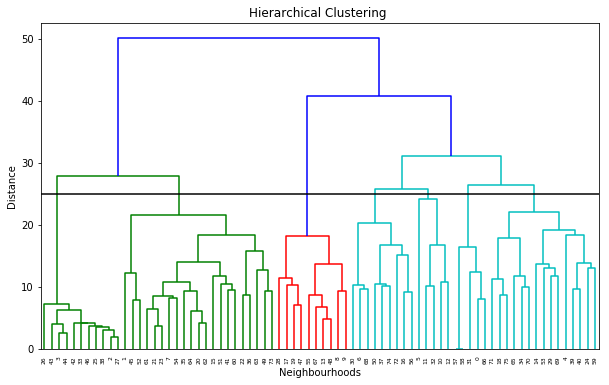

In [20]:
import scipy.cluster.hierarchy as shc

data = venues_grouped.iloc[:,3:]
plt.figure(figsize=(10, 6))   
plt.title('Hierarchical Clustering ')
plt.xlabel('Neighbourhoods')
plt.ylabel('Distance')
plt.axhline(y=25, c='k')
dend = shc.dendrogram(shc.linkage(data, method='ward'))

3.3 Base on the plot we will cluster the venus in 3 clusters

In [23]:
from sklearn.cluster import AgglomerativeClustering

kclusters= 3
cluster = AgglomerativeClustering(n_clusters=kclusters, affinity='euclidean', linkage='ward')  
clusterresult = cluster.fit_predict(data)

venues_grouped['NeighbourhoodsCluster'] = clusterresult
venues_cluster= df_barcelona.merge(venues_grouped[['Neighbourhoods','NeighbourhoodsCluster']])
venues_cluster.tail()

,Number,District,Population,Neighbourhoods,Latitude,Longitude,NeighbourhoodsCluster
71,9,Sant Andreu,"142,598",Bon Pastor,41.43636,2.20325,0
72,9,Sant Andreu,"142,598",El Congrés i els Indians,41.42492,2.18147,2
73,9,Sant Andreu,"142,598",Navas,41.90003,1.87838,1
74,9,Sant Andreu,"142,598",Sant Andreu de Palomar,41.43765,2.18962,0
75,9,Sant Andreu,"142,598",La Sagrera i Trinitat Vella,41.45087,2.19129,1


3.4 Lets plot the cluster map

In [24]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


for lat, lon, poi, cluster, sector,SectorPopulation  in zip(venues_cluster['Latitude'], venues_cluster['Longitude'], venues_cluster['Neighbourhoods'], venues_cluster['NeighbourhoodsCluster'], venues_cluster['District'],venues_cluster['Population']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster)+ ' ' + str(sector) + ' ' + str(SectorPopulation), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
folium.Marker(barcelona_center).add_to(map_clusters)
folium.Circle(barcelona_center, radius=2000, fill=False, color='white').add_to(map_clusters)
folium.Circle(barcelona_center, radius=4000, fill=False, color='white').add_to(map_clusters)
folium.Circle(barcelona_center, radius=6000, fill=False, color='white').add_to(map_clusters)
folium.Circle(barcelona_center, radius=10000, fill=False, color='black').add_to(map_clusters)         
map_clusters

Most common restaurants

In [27]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 3

columns = ['Neighbourhoods','Total Number of Venues']
indicators = ['st', 'nd', 'rd']


for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Restaurant'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Restaurant'.format(ind+1))


venues_most = pd.DataFrame(columns = columns)

for ind in range(venues_grouped.shape[0]):
    venues_most.loc[ind, 'Neighbourhoods'] = venues_grouped.iloc[ind].Neighbourhoods
    venues_most.loc[ind, 'Total Number of Venues'] = venues_grouped.iloc[ind,1:].sum()
    venues_most.iloc[ind, 2:] = return_most_common_venues(venues_grouped.iloc[ind, 1:], num_top_venues)

venues_most.head()

,Neighbourhoods,Total Number of Venues,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant
0,Bon Pastor,100,Clothing Store,Supermarket,Burger Joint
1,Can Baró,101,Bar,Spanish Restaurant,Park
2,Canyelles,5,NeighbourhoodsCluster,Pizza Place,BBQ Joint
3,Ciutat Meridiana,11,Metro Station,NeighbourhoodsCluster,Plaza
4,Diagonal Mar i el Front Marítim del Poblenou,100,Mediterranean Restaurant,Restaurant,Italian Restaurant


Merge it

In [30]:
venues_cluster= venues_cluster.merge(venues_grouped[['Neighbourhoods','NeighbourhoodsCluster']])
venues_cluster =venues_cluster.merge(venues_most[['Neighbourhoods','1st Most Common Restaurant','2nd Most Common Restaurant','3rd Most Common Restaurant']])

In [33]:
venues_cluster.groupby(['NeighbourhoodsCluster','1st Most Common Restaurant' ]).count()[['Neighbourhoods']].rename(columns={"Neighbourhoods": "Neighbourhoods Count"})


Neighbourhoods Count
NeighbourhoodsCluster 1st Most Common Restaurant                      
0                     Bakery                                         1
                      Clothing Store                                 4
                      Hotel                                          4
                      Italian Restaurant                             3
                      Japanese Restaurant                            1
                      Mediterranean Restaurant                       3
                      Pizza Place                                    3
                      Restaurant                                     2
                      Spanish Restaurant                             4
                      Tapas Restaurant                               9
1                     Bakery                                         2
                      Bar                                            1
                      Café                                           1
                      Gym / Fitness Center                           1
                      Metro Station                                  3
                      NeighbourhoodsCluster                          6
                      Park                                           3
                      Spanish Restaurant                             9
                      Supermarket                                    2
                      Tapas Restaurant                               3
                      Train Station                                  1
2                     Bar                                            1
                      Grocery Store                                  3
                      Spanish Restaurant                             1
                      Tapas Restaurant                               5

In [34]:
venues_cluster.groupby(['NeighbourhoodsCluster','2nd Most Common Restaurant' ]).count()[['Neighbourhoods']].rename(columns={"Neighbourhoods": "Neighbourhoods Count"})

Neighbourhoods Count
NeighbourhoodsCluster 2nd Most Common Restaurant                      
0                     Bakery                                         2
                      Bar                                            1
                      Burger Joint                                   2
                      Café                                           1
                      Coffee Shop                                    2
                      Hostel                                         1
                      Hotel                                          3
                      Japanese Restaurant                            1
                      Mediterranean Restaurant                       2
                      Park                                           1
                      Plaza                                          1
                      Restaurant                                     6
                      Spanish Restaurant                             7
                      Supermarket                                    1
                      Tapas Restaurant                               3
1                     Bakery                                         1
                      Café                                           4
                      Gourmet Shop                                   1
                      Grocery Store                                  5
                      Hotel                                          1
                      Mediterranean Restaurant                       1
                      NeighbourhoodsCluster                          2
                      Park                                           1
                      Pizza Place                                    1
                      Plaza                                          3
                      Restaurant                                     3
                      Spanish Restaurant                             5
                      Stables                                        1
                      Tapas Restaurant                               3
2                     Café                                           1
                      Grocery Store                                  3
                      Restaurant                                     2
                      Spanish Restaurant                             2
                      Supermarket                                    1
                      Tapas Restaurant                               1

We can see cluster categories as below:

* Cluster 0 (Red) : Spanish food type Restaurant, Restaurant, Hotels
* Cluster 1 (Purple) : Grocery, cafes and Spanish type
* Cluster 2 (Green) : Tapas and Grocery



## 4. Results and discussion

The Cluster in Red is related with the tourist place, hotels full with typical food and cafes, all clusters have Spanish food. However opening a peruvian restaurant is more related with people that want to try a different cuisine as peruvian food is known for being expensive and one the best ones in the world. So we will not see the traditional restaurant as competition. 

Depending on the segment of the population that we want to target the decision can be made.

It appears that the city and each neighbourhood has similarity between each other, all of them have spanish type cuisine, cafes, grocery. Only the center is related with other type of cuisines.


## 5. Conclusion

1. El Gotic or Dreta de l'Eixample: If the peruvian that is going to be open is an expensive the best place to put will be near the center of the city, as we saw these two neighbourhoods are the ones with less number of food related places and the ones that dont have any peruvian restaurants nearby. 

2. el Parc i la Llacuna del Poblenou: By looking to the current location of peruvian restaurants, they are located 4km away from the center, this neighbourhood is located in this area and doesnt have as many restaurants as other neighbourhoods.

3. Further investigation of the segmentation of the population and other cities close to Barcelona as Espluges and Hospitalet,  that are well known for having a high quantity of migrants,is needed. Maybe these places can open an economic version of a peruvian restaurante for these people